# Analysis

## Setup

In [261]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [285]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [286]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Get all cells info

In [422]:
nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [17]:
# # # IF NEED TO CELL TYPE....


# json_path = Path(settings_dict['save_dir'])
# filename = 'cell_graph_644143297__2023-04-18 20.22.35.json'
# filepath = json_path / filename

# crest = ecrest(settings_dict,filepath= filepath)#, launch_viewer=False)


# # Assign the cell type and which method you are using (manual or auto)
# cell_type = 'mg1'
# method = 'manual'

# ## Do not edit
# crest.define_ctype(cell_type,method)

# crest.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); 

Saved cell 644143297 reconstruction locally at 2023-04-19 16.57.21


## Get all segments

In [423]:

# Create a base_segments dictionary of all reconstructed cells 
'''
when done, can this be saved as a json? maybe quicker to load than to re-go through all cells?
'''

base_segments = {}
for x in nodes:
    # if cell_type[x] in network_types: # if do this, you can't check if the post-syn segments exist as a reconstruction
    cell = ecrest(settings_dict,filepath = nodefiles[x])#,launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

## Build Graph

In [424]:
network_types = ['mg1','mg2','lg','lf']

In [425]:
ell = ig_Graph(directed = True) 
ell.add_vertices([n for n in nodes if cell_type[n] in network_types])

# assign cell types to each node
for x in ell.vs:
    x['cell_type'] = cell_type[x['name']]

In [ ]:
# use this code cell to delete some of the vertices (cells)

# to_delete_ids = [v.index for v in ell.vs if v['cell_type'] not in ['mg2','lg','mg1','lf','lx','mgx']]
# ell.delete_vertices(to_delete_ids)

In [426]:

## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []
cells_with_synapses = []
cells_without_synapses = []
# for each node,

with tqdm(total=ell.vcount()) as pbar:
    for x_pre in ell.vs:
        pbar.update(1)
    # x_pre = ell.vs.find('128473437')

        # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
        pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']])#,launch_viewer=False)
        if pre.cell_data['end_points']['post-synaptic'] != []:

            cells_with_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])

            # for each synapse
            for syn_ in pre.cell_data['end_points']['post-synaptic']:
                try:
                    post_seg = syn_[3]

                    # go through each other nodes
                    for x_post in ell.vs:
                        post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)

                        for k,v in post.items():

                            for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                                if post_seg == v_: 
                                    # add edge to the graph between current node and matching node
                                    edge_list.append([x_pre['name'],x_post['name'],k])

                except IndexError as msg:
                    cellid = x_pre['name']
                    print(msg, f'for cell {cellid} synapse at syn_ has no segment id')

        else:
            cells_without_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
            cellid = x_pre['name']
            # print(f'no synapses for {cellid}')


100%|█████████████████████████████████████████| 156/156 [03:15<00:00,  1.26s/it]


### Edges

#### Ignore cell structure

If just want different cell pairs to count as unique (ignore morphology), use the following cell

In [427]:
edge_list_cell_pairs = [[r[0],r[1]] for r in edge_list]

edge_scaling = 10
df = pd.DataFrame(edge_list_cell_pairs,columns = ['pre','post'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'])#,structure = r['structure'])

In [429]:
df_edges

,pre,post,weight,weight_norm,pre_type,post_type
0,473631846,305332461,30,10.000000,mg2,lg
1,41579854,393063300,27,9.000000,mg1,lf
2,300131090,392814322,27,9.000000,mg1,lf
3,301308616,215403551,22,7.333333,mg2,lg
4,213669553,307591597,21,7.000000,mg1,lf
...,...,...,...,...,...,...
717,300316308,128737253,1,0.333333,mg2,mg1
718,300210608,49453764,1,0.333333,mg1,lf
719,300210608,394115741,1,0.333333,mg1,lf
720,300210608,387091598,1,0.333333,mg1,mg2


In [428]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as same)')

722 unique edges among:
76 unique pre synaptic cells - to - 147 unique post-synaptic cells (counts different structures on same cell as same)


In [430]:
df_edge_counts = df_edges[['pre_type','post_type']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

,,weight,weight_norm
pre_type,post_type,,
mg1,lf,965,321.666667


,,weight,weight_norm
pre_type,post_type,,
mg2,lg,1179,393.0


,,weight,weight_norm
pre_type,post_type,,
mg1,mg2,451,150.333333


,,weight,weight_norm
pre_type,post_type,,
mg2,mg1,473,157.666667


#### Cell Structures included

If want to count different cell structure targets as unique, use the following cell.  

If not, ignore it

In [273]:
edge_scaling = 10
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [274]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type","structure"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

930 unique edges among:
76 unique pre synaptic cells - to - 147 unique post-synaptic cells (counts different structures on same cell as different)


In [ ]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

### Check for any synapses on self

In [431]:
vx_sizes = [16, 16, 30]

for i,r in df_edges.iterrows():
    if r['pre']==r['post']:
        print(r['pre'])
        cell = ecrest(settings_dict,filepath = nodefiles[r['pre']])
        for syn_ in cell.cell_data['end_points']['post-synaptic']:
            post_seg = syn_[3]
            for i,s in enumerate(syn_[0:3]):
                syn_[i] = s/vx_sizes[i] 
            if post_seg in [str(a) for b in base_segments[r['pre']].values() for a in b]:
                print(f'delete synapse {syn_}')       
        

### print out quantifications

In [432]:
with pd.option_context('display.max_rows', 20):
    display(df_edges)

,pre,post,weight,weight_norm,pre_type,post_type
0,473631846,305332461,30,10.000000,mg2,lg
1,41579854,393063300,27,9.000000,mg1,lf
2,300131090,392814322,27,9.000000,mg1,lf
3,301308616,215403551,22,7.333333,mg2,lg
4,213669553,307591597,21,7.000000,mg1,lf
...,...,...,...,...,...,...
717,300316308,128737253,1,0.333333,mg2,mg1
718,300210608,49453764,1,0.333333,mg1,lf
719,300210608,394115741,1,0.333333,mg1,lf
720,300210608,387091598,1,0.333333,mg1,mg2


In [436]:
print(f'{len(ell.vs)} cells in the network that fall within cell types of interest (nodes in the graph):')
print('')
for ctype in ['lf','lg','mg1','mg2']:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e
print('')

df_allsyn = pd.DataFrame(cells_with_synapses)
print(f'{len(df_allsyn[df_allsyn[1].isin(["mg1","mg2"])])} of these are mg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["mg1","mg2"])][2].sum()} total post-synapstic segments labeled from mg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["mg1","mg2"])])} mg1/2 cells without labeled synapses')

156 cells in the network that fall within cell types of interest (nodes in the graph):

34 lf cells.
32 lg cells.
46 mg1 cells.
44 mg2 cells.

77 of these are mg cells with post-synaptic segments labeled for their synapses
5302 total post-synapstic segments labeled from mg_ cells in the network
13 mg1/2 cells without labeled synapses


summary of mg

In [437]:
print(f'{len(df)} synapses with reconstructed partners in current network,')
print(f'{df_edges[df_edges["pre_type"].str.contains("mg")]["weight"].sum()} synapses with reconstructed partners from mg cells pre-synaptically.')


print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print(f'{len(df_edges)} unique edges total (of various weights)')

with pd.option_context('display.max_rows', 10):
    display(df_edges)

3083 synapses with reconstructed partners in current network,
3083 synapses with reconstructed partners from mg cells pre-synaptically.
36 mg1 cells with 
1421 connected synapses with a reconstructed partner in these mg1
40 mg2 cells
1662 connected synapses with a reconstructed partner in these mg2
722 unique edges total (of various weights)


,pre,post,weight,weight_norm,pre_type,post_type
0,473631846,305332461,30,10.000000,mg2,lg
1,41579854,393063300,27,9.000000,mg1,lf
2,300131090,392814322,27,9.000000,mg1,lf
3,301308616,215403551,22,7.333333,mg2,lg
4,213669553,307591597,21,7.000000,mg1,lf
...,...,...,...,...,...,...
717,300316308,128737253,1,0.333333,mg2,mg1
718,300210608,49453764,1,0.333333,mg1,lf
719,300210608,394115741,1,0.333333,mg1,lf
720,300210608,387091598,1,0.333333,mg1,mg2


## If need to delete edges to re-do something...

In [9]:
# # if need to delete all edges...
# ell.delete_edges(range(len(ell.es)))

## Graphs

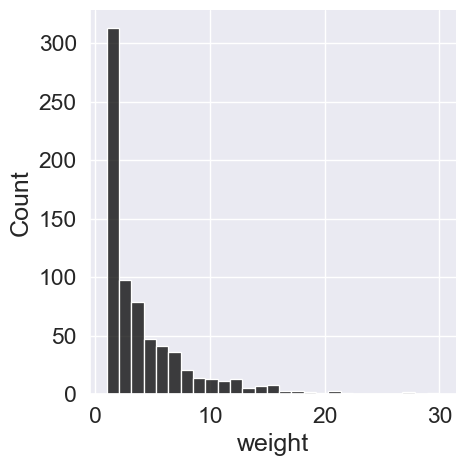

In [438]:
sns.displot(df_edges,x='weight',color='black');

In [339]:
palette ={"lg": "#ff0000", "lf": "#0000ff", "mg1": "#fd9400", "mg2": "#9934ff"}
sns.set(font_scale=1.5)

In [163]:
# colors = ["#fd9400", "#9934ff"] #color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff'}
# # Set your custom color palette
# sns.set_palette(sns.color_palette(colors))

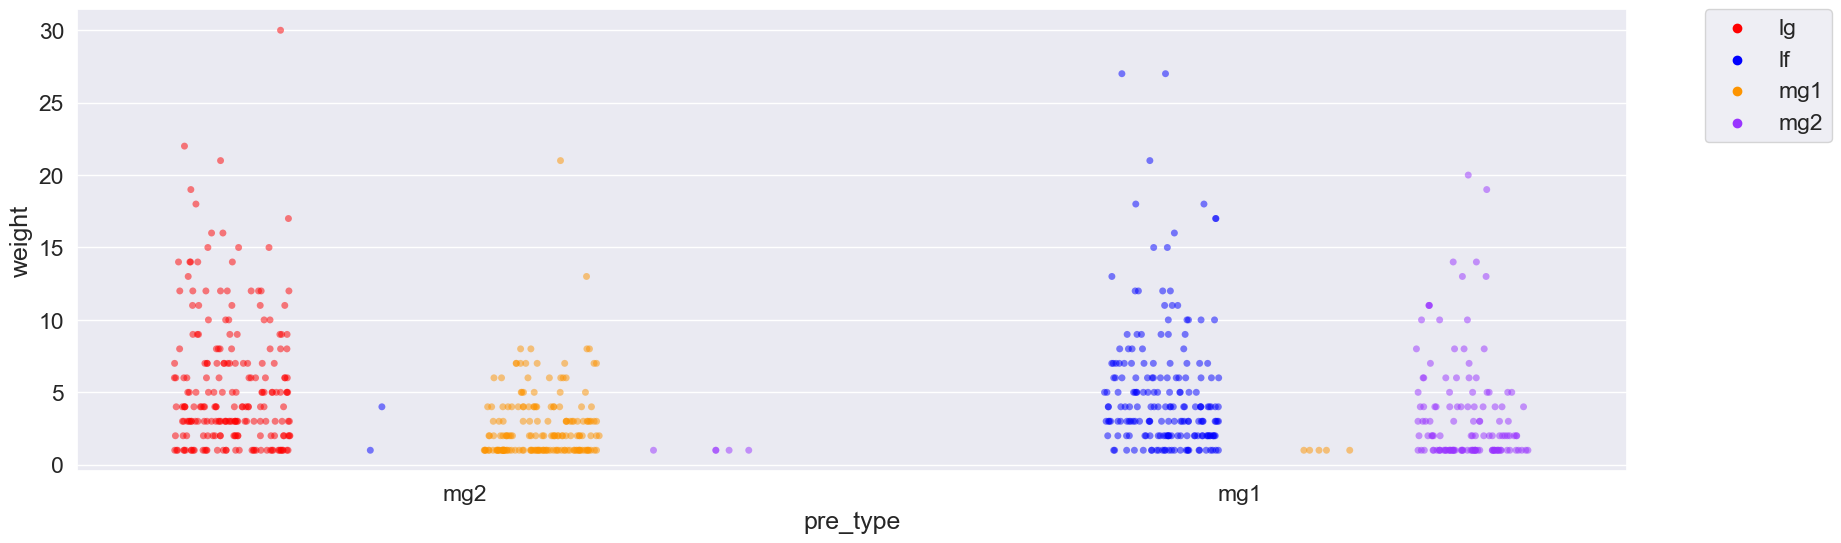

In [341]:
# df_edges['weight'].hist(bins=20)
plt.figure(figsize=(20,6))
sns.stripplot(df_edges,x='pre_type',y='weight',hue='post_type',dodge=True, jitter=0.3,alpha = 0.5,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

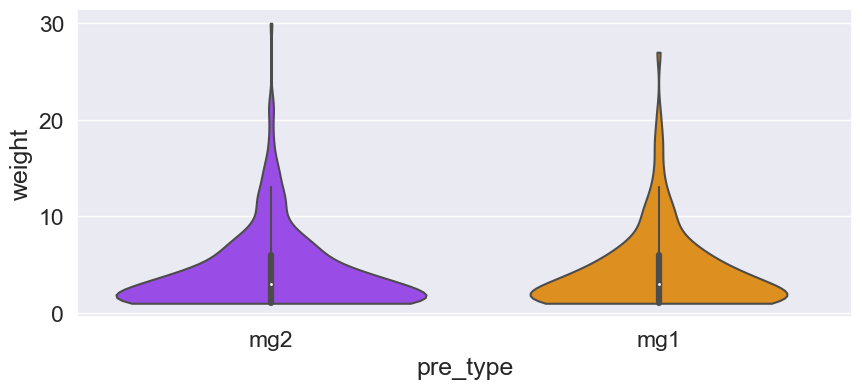

In [343]:
plt.figure(figsize=(10,4))
sns.violinplot(df_edges,x='pre_type',y='weight',scale='count',cut=0,palette=palette);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='pre_type',bw_adjust = 0.5)

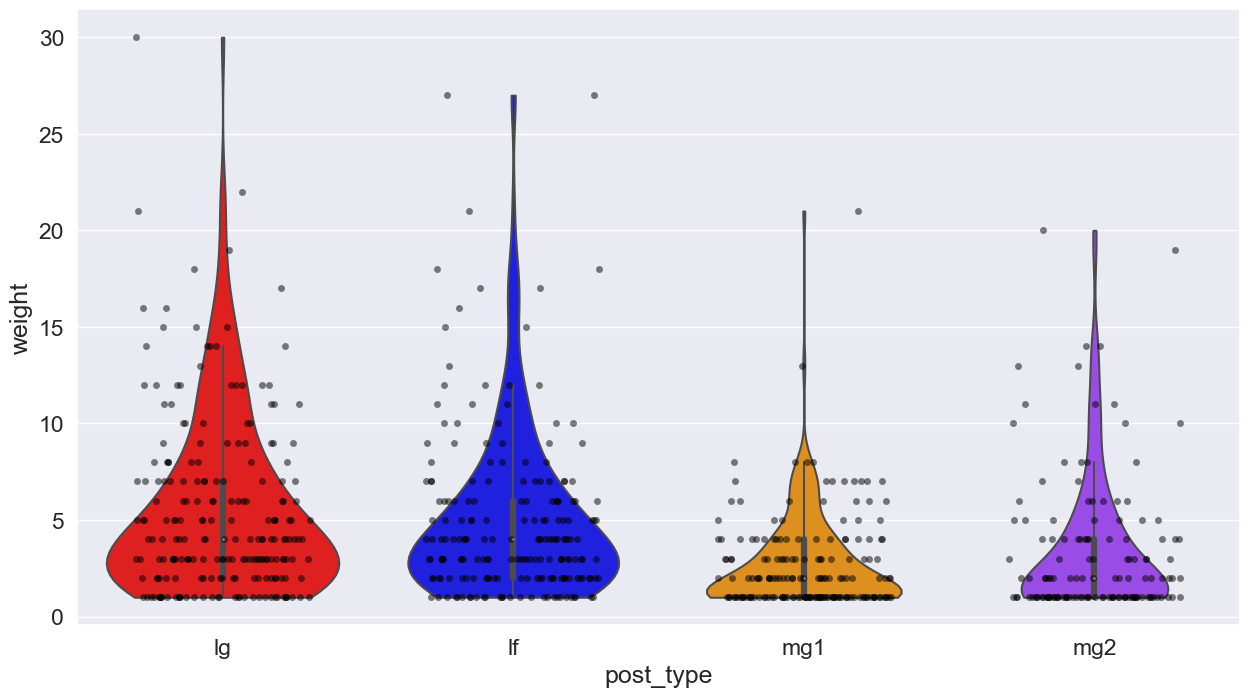

In [344]:
plt.figure(figsize=(15,8))
sns.violinplot(df_edges,x='post_type',y='weight',scale='count',cut=0,palette=palette)
sns.stripplot(df_edges,x='post_type',y='weight',color='black',alpha=0.5,jitter=0.3);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='post_type',bw_adjust = 0.5)

In [415]:
degree_in = ell.degree(mode="in")
degree_out = ell.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in ell.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in ell.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

,cell_id,converge,diverge,type
0,119793391,12,0,lg
1,126618353,10,18,mg1
...,...,...,...,...
154,652529320,2,0,lf
155,653504340,4,0,lf


<AxesSubplot:xlabel='type', ylabel='diverge'>

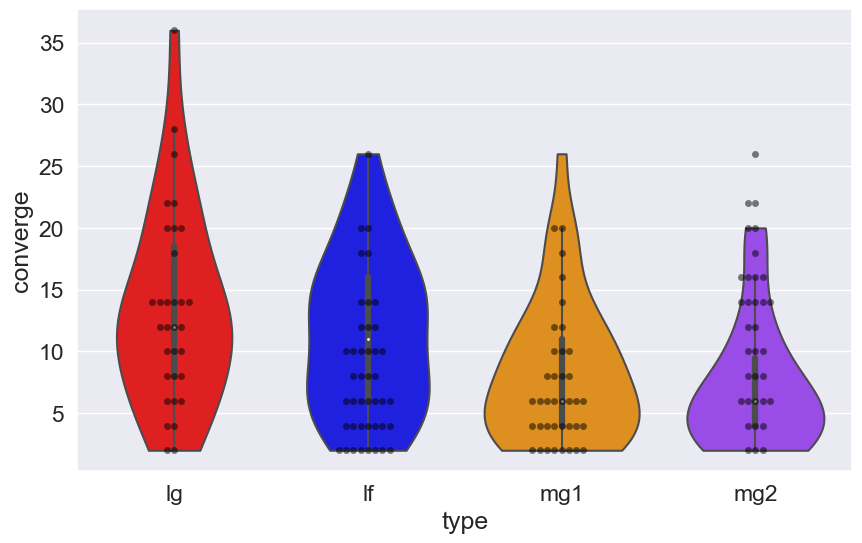

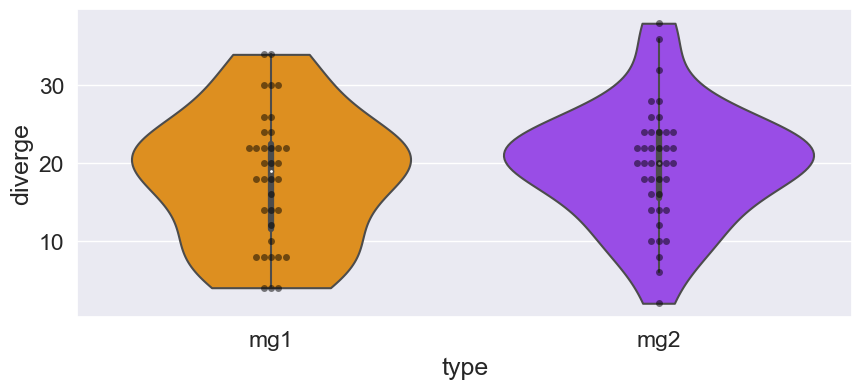

In [401]:
# sns.kdeplot(df_degree,x='converge',hue='type', bw_adjust = 0.75)
plt.figure(figsize=(10,6))
sns.violinplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',scale='count',cut=0,palette=palette,order=['lg','lf','mg1','mg2'])
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',color='black',alpha=0.5)#,jitter=0.25)
# sns.stripplot(df_degree,x='type',y='converge',alpha=0.5,jitter=0.25)

plt.figure(figsize=(10,4))
sns.violinplot(df_degree[(df_degree['type'].isin(['mg1','mg2'])) & (df_degree.diverge != 0)],y='diverge',x='type',scale='count',cut=0,palette=palette)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree['type'].isin(['mg1','mg2'])) & (df_degree.diverge != 0)],x='type',y='diverge',color='black',alpha=0.5)

[(0.0, 40.0)]

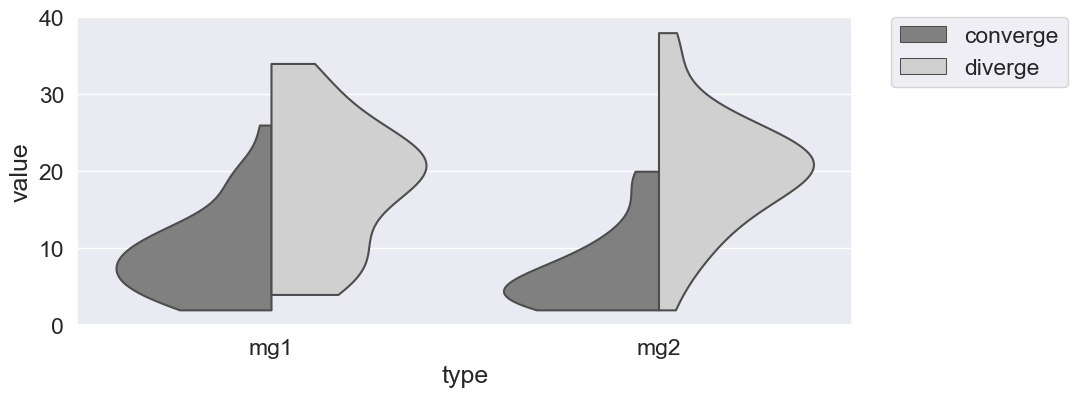

In [416]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree['type'].isin(['mg1','mg2'])) & (df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [411]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))])

,cell_id,converge,diverge,type
1,126618353,10,18,mg1
2,127870654,14,34,mg1
3,128473437,12,24,mg2
4,128536704,8,26,mg2
5,128737253,18,16,mg1
...,...,...,...,...
142,643848637,4,30,mg1
143,644005141,6,0,mg2
144,644143297,4,18,mg1
145,644823522,2,22,mg2


In [412]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))& (df_degree.diverge != 0) & (df_degree.converge != 0)])

,cell_id,converge,diverge,type
1,126618353,10,18,mg1
2,127870654,14,34,mg1
3,128473437,12,24,mg2
4,128536704,8,26,mg2
5,128737253,18,16,mg1
...,...,...,...,...
128,558300217,8,14,mg2
142,643848637,4,30,mg1
144,644143297,4,18,mg1
145,644823522,2,22,mg2


In [417]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")


In [418]:
degree_in = pruned_graph.degree(mode="in")
degree_out = pruned_graph.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in pruned_graph.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in pruned_graph.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

,cell_id,converge,diverge,type
0,126618353,10,10,mg1
1,127870654,14,14,mg1
...,...,...,...,...
88,644823522,2,8,mg2
89,644839915,8,10,mg2


[(0.0, 40.0)]

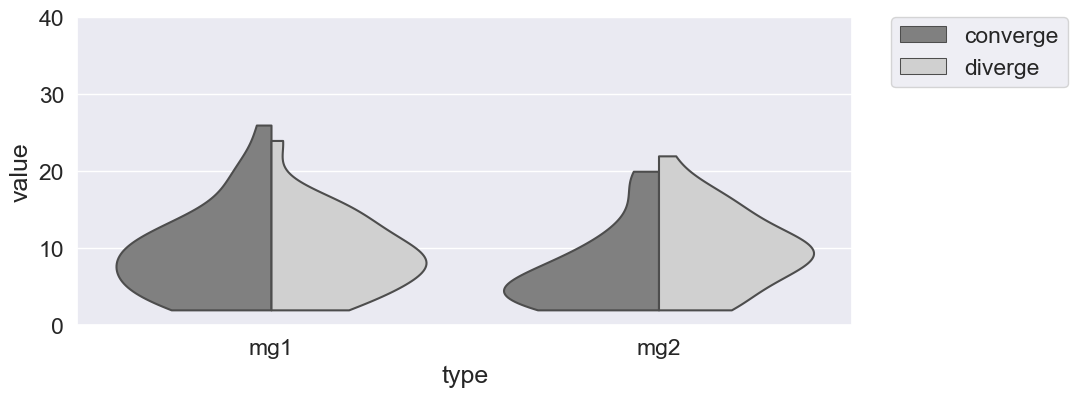

In [419]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [439]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [440]:
color_dict = {"unknown": "brown", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green", "multiple":"gray"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'
        # print(e)

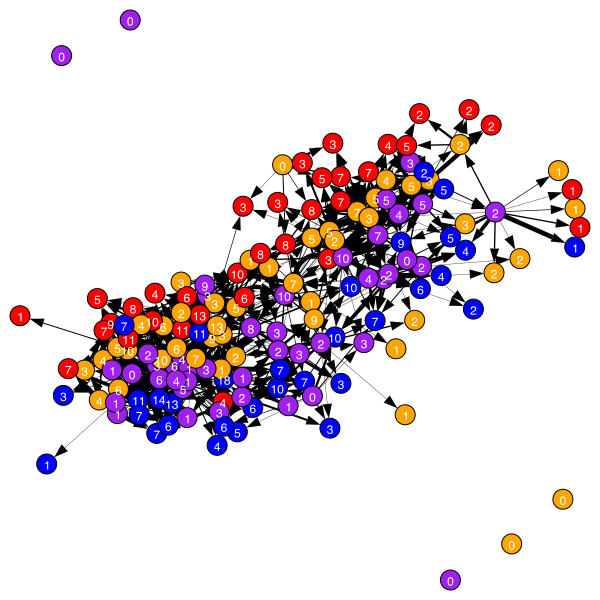

In [459]:
degree_all = ell.degree(mode="in")

# for i,d in enumerate(degree_all):
    # print(ell.vs[i]['cell_type'],d)

# labels = [n['name'] for n in ell.vs]

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all
# visual_style["arrow_size"]=0.1


ig_plot(ell,edge_width = ell.es['weight'],
        vertex_color=ell.vs['color'],
        edge_color = ell.es['color'], 
        **visual_style)#,vertex_label=labels)

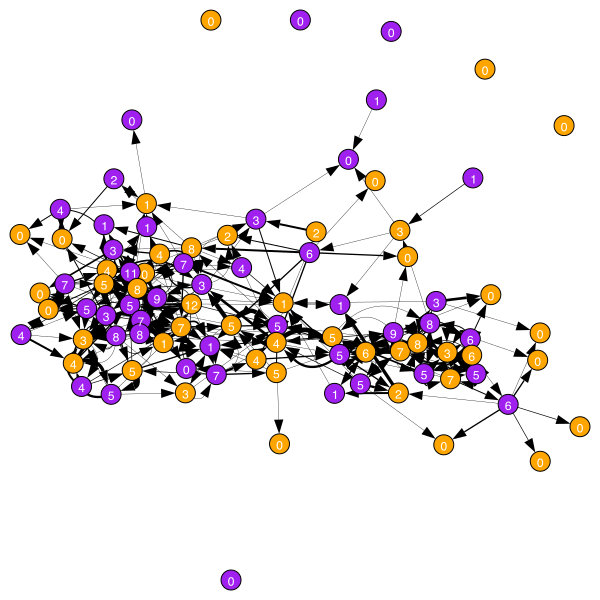

In [453]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'],
        **visual_style)#,vertex_label=labels)

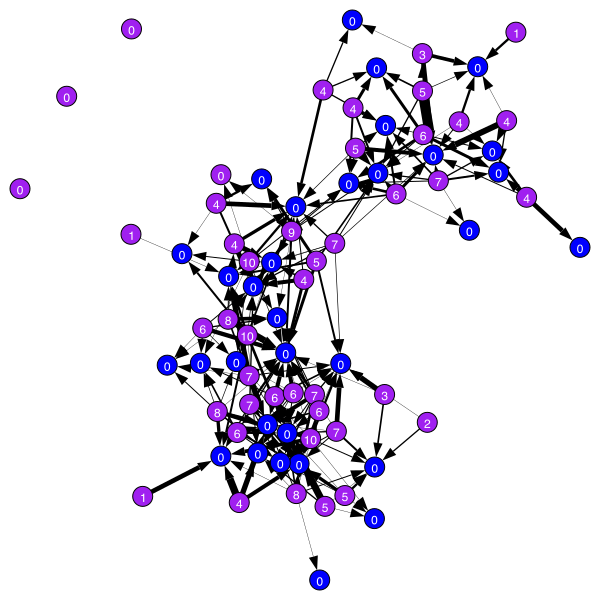

In [454]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

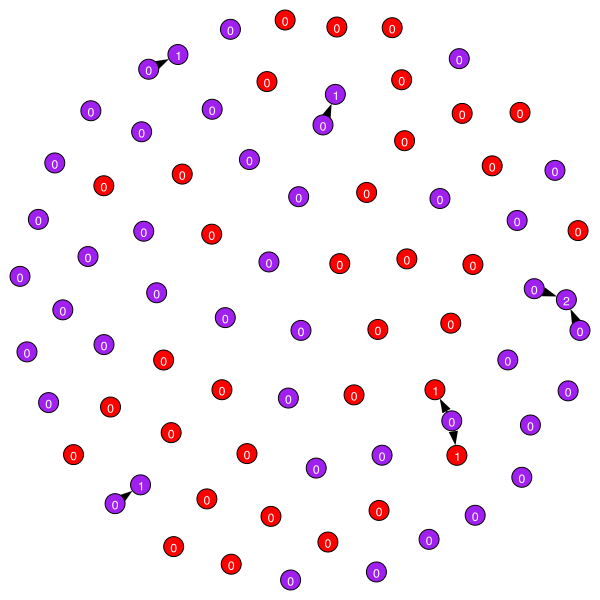

In [455]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

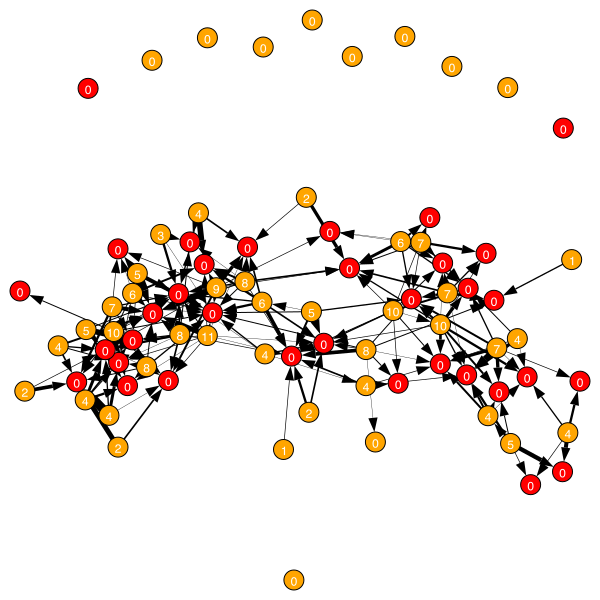

In [457]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

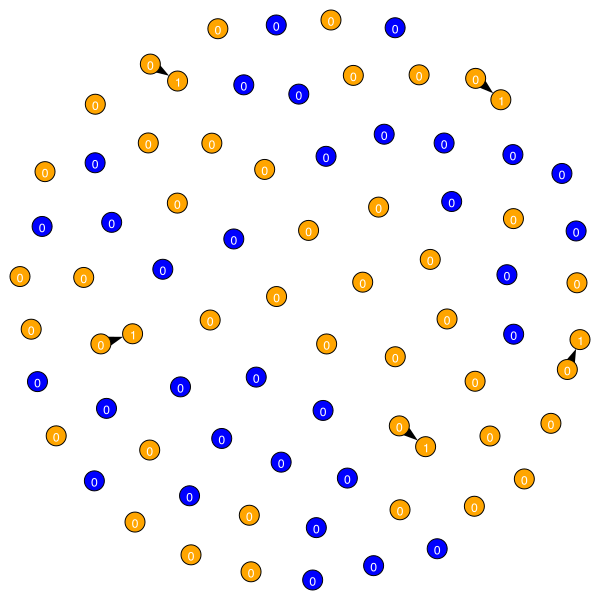

In [458]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

## Get all pre-synaptic cells to a specific cellID

In [280]:
df_edges[df_edges['post']=='393063300'].groupby('pre').sum(numeric_only=True)

,weight,weight_norm
pre,,
128737253,3,1.000000
214412684,12,4.000000
300210608,2,0.666667
386114963,6,2.000000
386224676,4,1.333333
41579854,27,9.000000
472114046,8,2.666667
472175645,18,6.000000
474236060,3,1.000000


## Check for duplicates in mg_network

In [282]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [283]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(dirpath)

In [284]:
df_all = pd.DataFrame()
for k,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    df = cell.check_duplicates(base_segments)
    if not df.empty:
        df_all = pd.concat([df_all,df]) 
        
display(df_all)

""


# create crest files for post-syn segments not in cells

In [122]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [125]:
# todo_dict= {}
# post_segs_without_cell = 0
# post_segs_with_cell = 0

all_syn = set()
for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is an mg cell and if it has post-synaptic segments labeled
    if ('mg' in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] != []):

        try:
        # for each synapse
            syn_to_find = set([syn_[3] for syn_ in pre.cell_data['end_points']['post-synaptic']])
            for x_post in nodes:
                post_segs = set([a for b in base_segments[x_post].values() for a in b])    
                syn_to_find = syn_to_find.difference(post_segs)

            all_syn = all_syn.union(syn_to_find)
        
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')
        

In [129]:
len(all_syn)

1504

In [ ]:
todo_dict = {}
for post_seg in list(all_syn):
    post = ecrest(settings_dict,segment_id = post_seg,launch_viewer=False)
    todo_dict[post_seg] = set(post.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [131]:
len(todo_dict)

1504

In [132]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [133]:
len(topop)

208

In [134]:
for segid in topop:
    todo_dict.pop(segid)
    

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_post-synaptic')
    



# Find & Delete GLIA "post-synaptic" segments from jsons



In [90]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [91]:
glia_seg = ['479108445']

In [92]:
anno_to_remove = {}

vx_sizes = [16, 16, 30]
# for each node,
for n in nodes:

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[n],launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try: 
                if syn_[3] in glia_seg:
                    anno_to_remove[nodefiles[n]] = syn_


            except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')

In [93]:
anno_to_remove

{PosixPath('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_474357461__2023-05-11 14.05.25.json'): [234128.0,
  308944.0,
  81030.0,
  '479108445']}

In [59]:
f = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/todo_post-synaptic/glia/cell_graph_43621743__2023-04-20 08.33.58.json'
pre = ecrest(settings_dict,filepath = f,launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 1, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0


In [94]:
# filepath = json_path / filename
for f,anno in anno_to_remove.items():
    pre = ecrest(settings_dict,filepath = f,launch_viewer=False)
    updated_anno = [i for i in pre.cell_data['end_points']['post-synaptic'] if i[3] not in [anno[3]]]
    pre.cell_data['end_points']['post-synaptic'] = updated_anno
    
    # print(f.name)
    pre.save_cell_graph(directory_path = f.parent, file_name=f.name, save_to_cloud=False); 
    # print(len(pre.cell_data['end_points']['post-synaptic']),len(updated_anno))

Saved cell 474357461 reconstruction locally at 2023-05-12 20.14.53


# GET most recent files (by filename date) in folder

In [281]:
# dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# # os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

# names = os.listdir(dirname);
# cellid_filename=list();
# for ind in range(len(names)):
#     content = names[ind].split('_')
#     if ('cell' in content):
#         cellid_filename.append(names[ind])
dirpath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network')#/todo_pre-synaptic/basal-dendrite')

cellid_filename = [child.name for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            print(f'newer file exists for {ID}')
            
# ############################################################################################################################ 
# # Collect all the base segments for each ID
# import json

# base_segs = {}

# for key in d.keys():
#     f = open(dirname+d[key][1])
#     data = json.load(f)
#     base_segs[key]=sum(data['base_segments'].values(),[])
#     f.close()

# ############################################################################################################################ 


newer file exists for 644005141


# Pre-synaptic reconstruction from synapses

In [239]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


In [240]:
json_path = Path(settings_dict['save_dir']) #/ 'todo_post-synaptic' #/ 'check-duplicates' #'CC unsure'
filename = 'cell_graph_386392158__2023-05-22 14.40.21.json'

crest = ecrest(settings_dict,filepath= json_path / filename, launch_viewer=False)


In [244]:
vx_sizes = [16, 16, 30]

syn_to_find = set([syn_[3] for syn_ in crest.cell_data['end_points']['pre-synaptic'] if int(syn_[1]/vx_sizes[1])>17070])

In [245]:
len(syn_to_find)

86

In [83]:
# [np.asarray(syn_[0:2])/16 for syn_ in crest.cell_data['end_points']['pre-synaptic'] if syn_[3] in ['394395122']]

First, find if any of these post-synaptic segments are already part of reconstructions completed

In [246]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']))

In [247]:
topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

use reconstruction 299392199
use reconstruction 300472342
use reconstruction 558191083


In [248]:
topop

{'301647214', '393231844', '393249008', '479109096'}

In [249]:
syn_to_find = syn_to_find.difference(topop)

In [250]:
len(syn_to_find)

82

In [251]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir'])/'todo_pre-synaptic/basal-dendrite_mg2')

In [252]:
topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

use reconstruction 142603072
use reconstruction 300505542
use reconstruction 302808506
use reconstruction 302809903
use reconstruction 303939652
use reconstruction 386455093
use reconstruction 389811669
use reconstruction 389811950
use reconstruction 389811976
use reconstruction 390956854
use reconstruction 390957492
use reconstruction 392087810
use reconstruction 392088645
use reconstruction 393233147
use reconstruction 393249410
use reconstruction 394395368
use reconstruction 394395379
use reconstruction 395555702
use reconstruction 473460724
use reconstruction 473461904
use reconstruction 474542741
use reconstruction 479124040
use reconstruction 480267017
use reconstruction 480267674
use reconstruction 480267823
use reconstruction 480267921
use reconstruction 480284614
use reconstruction 480285263
use reconstruction 481429970
use reconstruction 559228683
use reconstruction 559257305
use reconstruction 560450043
use reconstruction 560465610
use reconstruction 561609054
use reconstruc

In [253]:
len(topop)

56

In [254]:
syn_to_find = syn_to_find.difference(topop)

In [259]:
len(syn_to_find)

26

In [256]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir'])/'todo_pre-synaptic/basal-dendrite_mg1')

In [257]:
topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

create crest files for each of the unidentified post-synaptic partners

In [258]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


Save reconstructed_segs as a json to go through manually

In [ ]:
for segment_id in sorted(list(syn_to_find)):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_pre-synaptic/basal-dendrite_mg2')

# Other

## Fix cell_data dictionary keys


In [90]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_305332461__2023-04-01 21.04.03.json"

In [91]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [92]:
old_points = cell.cell_data['end_points']
old_points

{'exit volume': [],
 'natural': [],
 'bad alignment': [],
 'uncorrected split': [],
 'artefact': [],
 'natural end': [],
 'uncertain': [],
 'pre-synaptic': [],
 'post-synaptic': []}

In [93]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [66]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [94]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

dict_keys(['exit volume', 'natural end', 'uncertain', 'pre-synaptic', 'post-synaptic'])

In [95]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

Saved cell 305332461 reconstruction locally at 2023-04-05 11.20.24


## Figure out what is wrong with a crest file

In [125]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [127]:
cell.cell_data['end_points']['post-synaptic']

[]

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [157]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [158]:
cells_to_fix = cells_to_fix['cell_info']

In [163]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

Saved cell 214412684 reconstruction locally at 2023-04-05 12.11.10
Saved cell 214550811 reconstruction locally at 2023-04-05 12.11.10
Saved cell 215572949 reconstruction locally at 2023-04-05 12.11.10
Saved cell 216129202 reconstruction locally at 2023-04-05 12.11.10
Saved cell 220275752 reconstruction locally at 2023-04-05 12.11.10
Saved cell 297178666 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299497999 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299589324 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300210608 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300316308 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300380579 reconstruction locally at 2023-04-05 12.11.10
"305035439'"
Saved cell 31102601 reconstruction locally at 2023-04-05 12.11.10
Saved cell 387368998 reconstruction locally at 2023-04-05 12.11.10
Saved cell 392213717 reconstruction locally at 2023-04-05 12.11.10
Saved cell 42802314 reconstruction locally at 2023

## Anatomical Clustering